# Test Data Preparation and Testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
from hampel import hampel
from tqdm.notebook import trange, tqdm

In [2]:
file = 'data_collection/test_2/mixed_200s.xlsx'
df = pd.read_excel(file)
emg_labels = ['emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
df.columns = ['t[s]']+emg_labels
df

,t[s],emg1,emg2,emg3,emg4,emg5,emg6,emg7,emg8
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
430669,200.483845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
430670,200.484310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
430671,200.484776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
430672,200.485241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


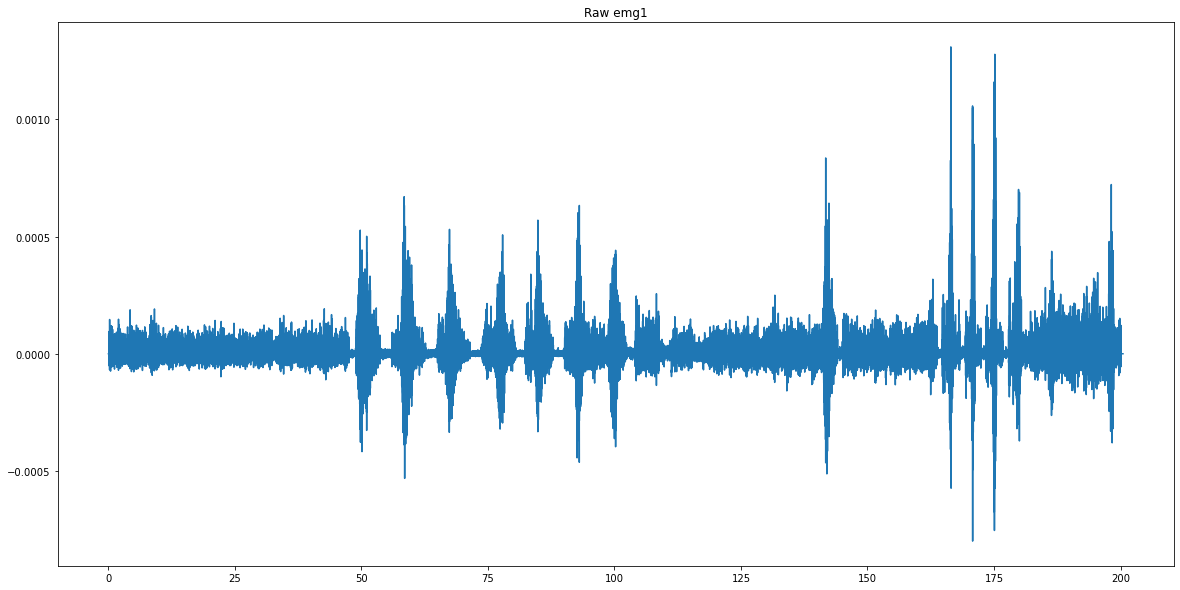

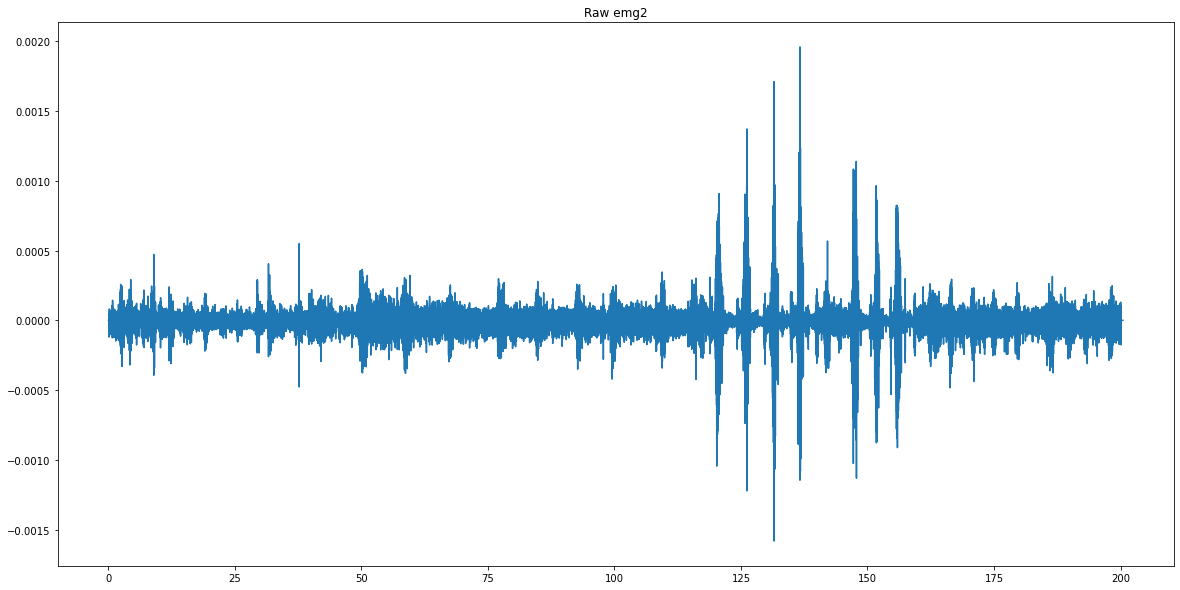

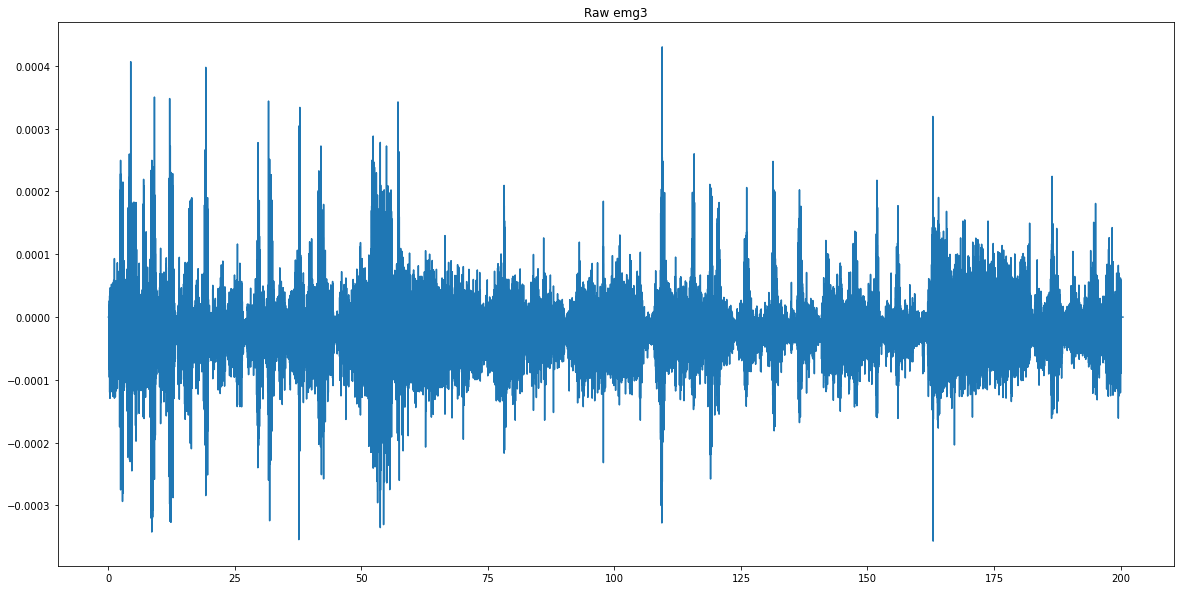

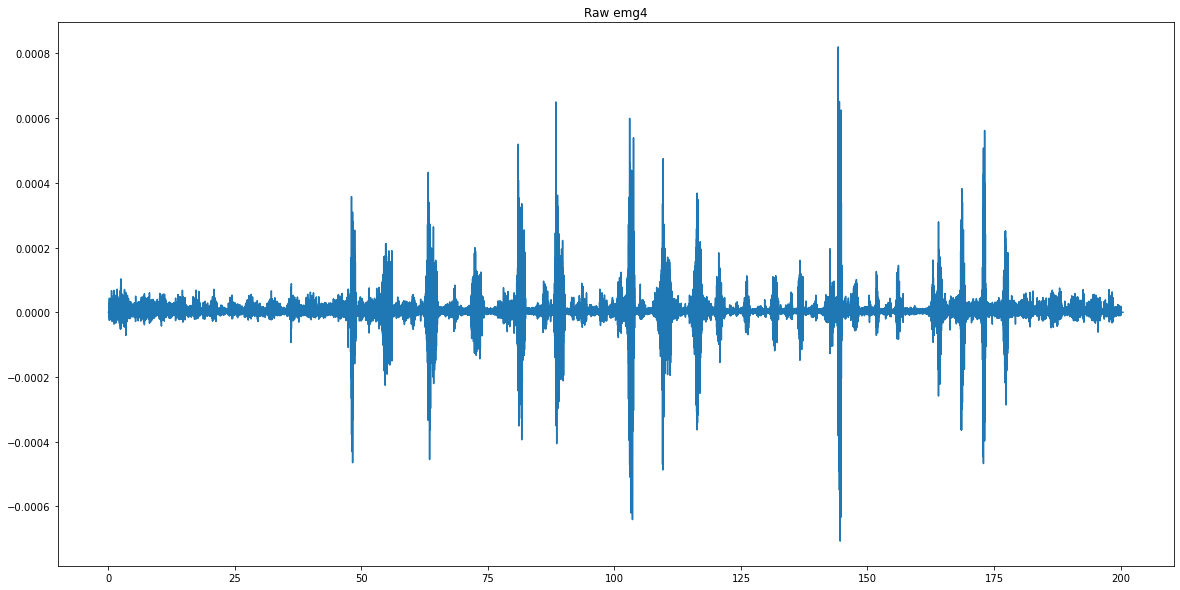

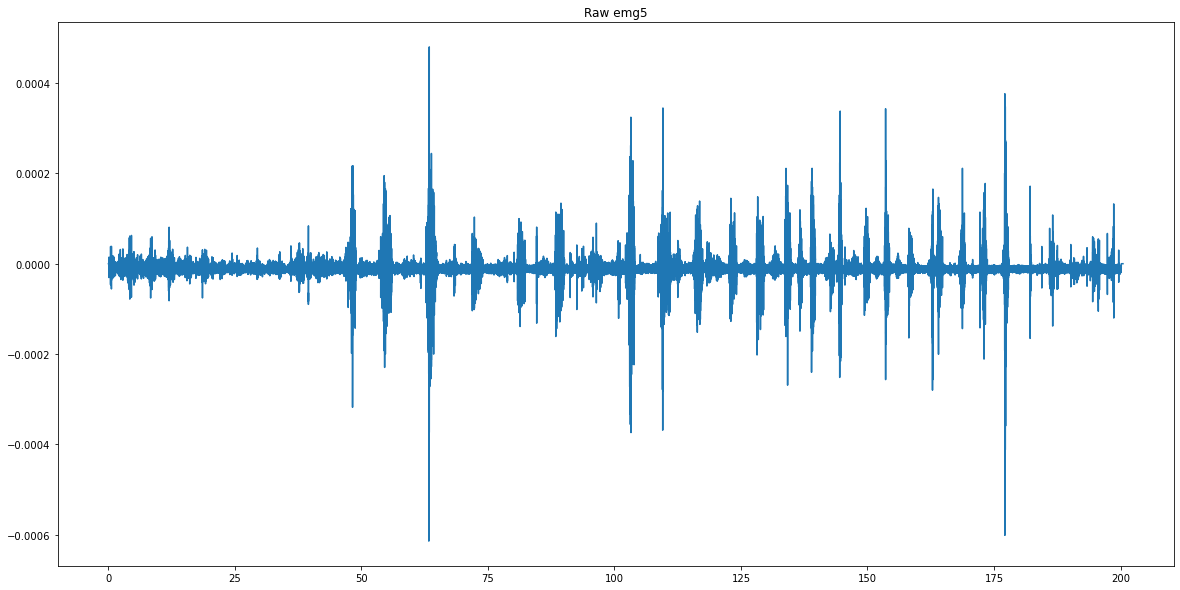

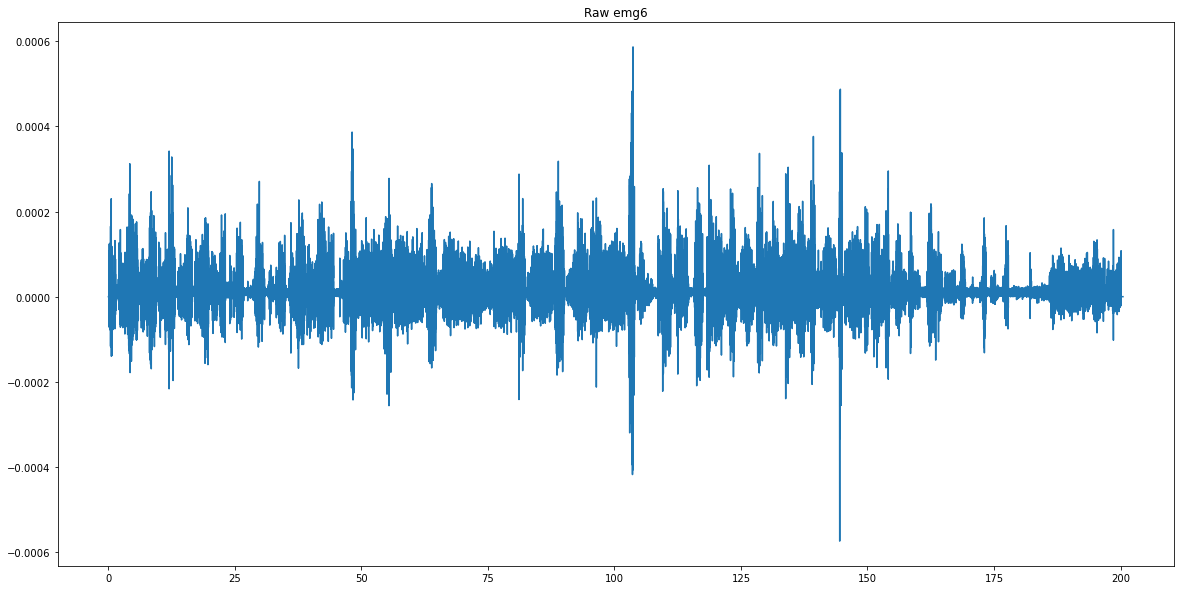

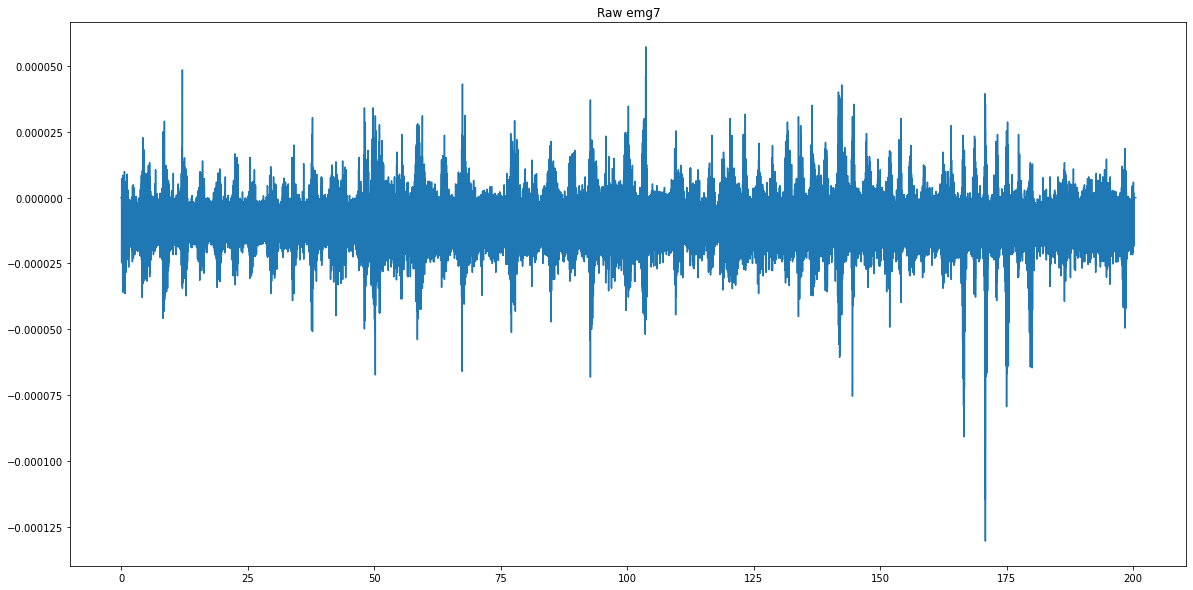

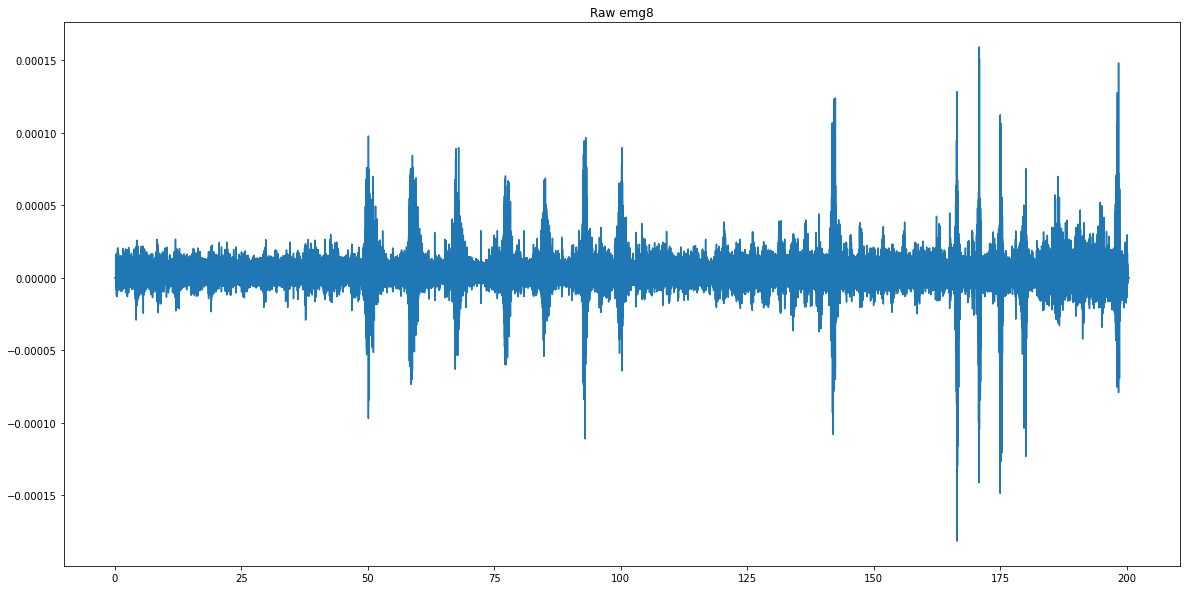

In [3]:
for label in emg_labels:
    plt.figure(figsize=(20,10))
    plt.title('Raw '+label)
    plt.plot(df['t[s]'],df[label])
    plt.show()

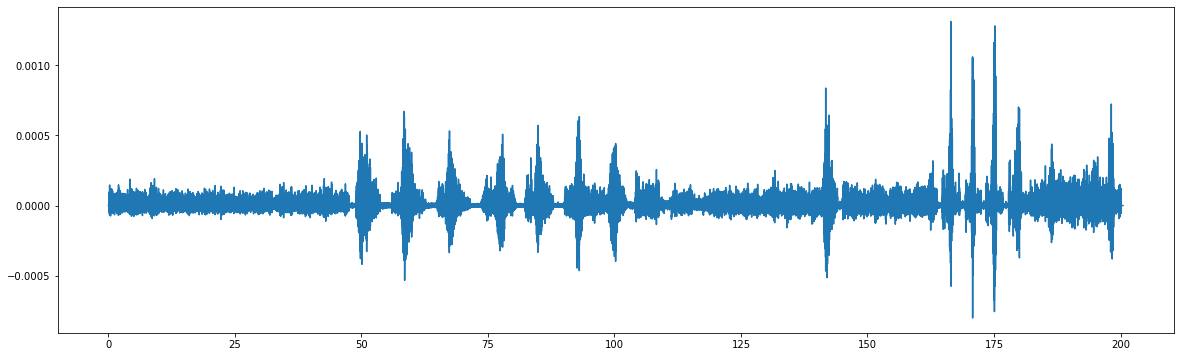

In [4]:
EMG1 = df['emg1']
plt.figure(figsize=(20,6))
plt.plot(df['t[s]'],EMG1)
plt.show()

In [32]:
ham = hampel(EMG1, window_size=50, n=3, imputation=True)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(df['t[s]'],ham)
plt.show()

## Make windowed Data

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
def make_windowed(data,win_len):
    nb = data.shape[0]
    X = []
    for i in tqdm(range(nb-win_len)):
        X.append(data[i:i+win_len])
    return np.array(X)

In [7]:
emg_df = df[emg_labels]

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=False).fit(emg_df)

In [9]:
print(scaler.mean_)
print(scaler.scale_)
print(scaler.n_features_in_)
print(scaler.n_samples_seen_)
print(scaler.var_)

[ 1.77411426e-07 -1.13069887e-05 -2.24316518e-05  3.02296806e-06
 -1.19303558e-05  1.05418649e-05 -9.57976447e-06  3.66126473e-06]
[4.42477875e-05 5.21967146e-05 2.42753723e-05 2.39566300e-05
 1.67912108e-05 2.71842325e-05 5.72116270e-06 7.72612906e-06]
8
430674
[1.95786669e-09 2.72449702e-09 5.89293699e-10 5.73920120e-10
 2.81944761e-10 7.38982496e-10 3.27317026e-11 5.96930703e-11]


## Normalize whole DB

In [10]:
emg_df = scaler.transform(emg_df)

In [11]:
np.save('Myotron_Controll_codes/sim_data/norm_emg_200s',emg_df)

In [12]:
windowed_test = make_windowed(emg_df,250)

In [16]:
np.save('Myotron_Controll_codes/sim_data/test2_mixed_windowed_200s',windowed_test)

In [17]:
windowed_test = np.load('Myotron_Controll_codes/sim_data/test2_mixed_windowed_200s.npy')

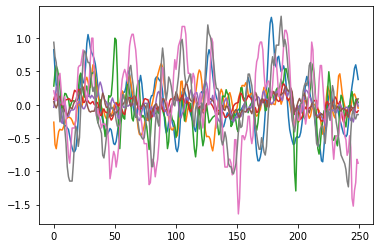

In [18]:
plt.plot(windowed_test[50000])
plt.show()

In [24]:
from keras.models import load_model
file = 'models/wrist_model_250_89'
model = load_model(file)

In [25]:
def wrist_classifier(data):
    data = np.array(data) 
    data = np.reshape(data,(1,250,8))
    pred = model.predict(data,batch_size=1)[0]
    return pred

In [26]:
time = 60+41
frame = int(time*(6011/180))
nx = int(windowed_data.shape[0]/180)
ts = time*nx
print('Time - ',time,' frame - ',frame,' T[s] - ',ts)
all_window_ts = windowed_data[ts-nx:ts]

Time -  101  frame -  3042  T[s] -  241491


In [27]:
wrist_moves = ['Suplination - CW (rot axis Mid finger)',
               'Pronation - CCW (rot axis Mid finger)',
               'Suplination - CW (rot axis lit finger)',
               'Pronation - CCW (rot axis lit finger)',
               'Flexion - Bend Towards',' Extension - Bend Backward',
               'Radial - Left - CCW',
               'Radial - Righ - CW',
               'Extension with closed hand']

In [28]:
i = 0
for d in all_window_ts:
    i=i+1
    soft_pred = wrist_classifier(d)
    clf = np.argmax(np.array(soft_pred))
    print('[',i,'] ',wrist_moves[clf],' ',soft_pred[clf]*100)

[ 1 ]  Pronation - CCW (rot axis lit finger)   49.13467764854431
[ 2 ]  Suplination - CW (rot axis lit finger)   53.2665491104126
[ 3 ]  Suplination - CW (rot axis lit finger)   50.802081823349
[ 4 ]  Pronation - CCW (rot axis lit finger)   51.66216492652893
[ 5 ]  Suplination - CW (rot axis lit finger)   56.712108850479126
[ 6 ]  Suplination - CW (rot axis lit finger)   65.14284014701843
[ 7 ]  Suplination - CW (rot axis lit finger)   87.79725432395935
[ 8 ]  Suplination - CW (rot axis lit finger)   92.85630583763123
[ 9 ]  Suplination - CW (rot axis lit finger)   92.51803159713745
[ 10 ]  Suplination - CW (rot axis lit finger)   86.0257625579834
[ 11 ]  Suplination - CW (rot axis lit finger)   94.15816068649292
[ 12 ]  Suplination - CW (rot axis lit finger)   92.02920198440552
[ 13 ]  Suplination - CW (rot axis lit finger)   91.56762361526489
[ 14 ]  Suplination - CW (rot axis lit finger)   94.56484317779541
[ 15 ]  Suplination - CW (rot axis lit finger)   99.36637878417969
[ 16 ]  S

[ 133 ]  Pronation - CCW (rot axis lit finger)   66.24408960342407
[ 134 ]  Suplination - CW (rot axis lit finger)   68.883615732193
[ 135 ]  Pronation - CCW (rot axis lit finger)   76.7832100391388
[ 136 ]  Suplination - CW (rot axis lit finger)   58.66234302520752
[ 137 ]  Pronation - CCW (rot axis lit finger)   91.93188548088074
[ 138 ]  Pronation - CCW (rot axis lit finger)   93.1752622127533
[ 139 ]  Pronation - CCW (rot axis lit finger)   93.18286180496216
[ 140 ]  Pronation - CCW (rot axis lit finger)   95.89187502861023
[ 141 ]  Pronation - CCW (rot axis lit finger)   85.23812890052795
[ 142 ]  Pronation - CCW (rot axis lit finger)   87.25107312202454
[ 143 ]  Pronation - CCW (rot axis lit finger)   75.72614550590515
[ 144 ]  Pronation - CCW (rot axis lit finger)   81.68234825134277
[ 145 ]  Pronation - CCW (rot axis lit finger)   78.41508388519287
[ 146 ]  Pronation - CCW (rot axis lit finger)   61.11958026885986
[ 147 ]  Pronation - CCW (rot axis lit finger)   63.894867897033

[ 260 ]  Pronation - CCW (rot axis lit finger)   64.53708410263062
[ 261 ]  Pronation - CCW (rot axis lit finger)   60.060566663742065
[ 262 ]  Pronation - CCW (rot axis lit finger)   51.771676540374756
[ 263 ]  Suplination - CW (rot axis lit finger)   59.396564960479736
[ 264 ]  Pronation - CCW (rot axis lit finger)   55.73882460594177
[ 265 ]  Suplination - CW (rot axis lit finger)   70.40427327156067
[ 266 ]  Suplination - CW (rot axis lit finger)   91.75776839256287
[ 267 ]  Suplination - CW (rot axis lit finger)   95.09831666946411
[ 268 ]  Suplination - CW (rot axis lit finger)   91.20016694068909
[ 269 ]  Pronation - CCW (rot axis lit finger)   54.010164737701416
[ 270 ]  Pronation - CCW (rot axis lit finger)   90.41573405265808
[ 271 ]  Pronation - CCW (rot axis lit finger)   80.38608431816101
[ 272 ]  Pronation - CCW (rot axis lit finger)   79.67477440834045
[ 273 ]  Pronation - CCW (rot axis lit finger)   84.00843739509583
[ 274 ]  Pronation - CCW (rot axis lit finger)   85.9

[ 387 ]  Pronation - CCW (rot axis lit finger)   96.77987098693848
[ 388 ]  Pronation - CCW (rot axis lit finger)   97.38141298294067
[ 389 ]  Pronation - CCW (rot axis lit finger)   97.16037511825562
[ 390 ]  Pronation - CCW (rot axis lit finger)   98.38942885398865
[ 391 ]  Pronation - CCW (rot axis lit finger)   99.13747906684875
[ 392 ]  Pronation - CCW (rot axis lit finger)   99.54641461372375
[ 393 ]  Pronation - CCW (rot axis lit finger)   99.2602527141571
[ 394 ]  Pronation - CCW (rot axis lit finger)   97.14316725730896
[ 395 ]  Pronation - CCW (rot axis lit finger)   98.99528622627258
[ 396 ]  Pronation - CCW (rot axis lit finger)   96.1207389831543
[ 397 ]  Pronation - CCW (rot axis lit finger)   91.18817448616028
[ 398 ]  Pronation - CCW (rot axis lit finger)   96.87920808792114
[ 399 ]  Pronation - CCW (rot axis lit finger)   98.9116370677948
[ 400 ]  Pronation - CCW (rot axis lit finger)   97.83106446266174
[ 401 ]  Pronation - CCW (rot axis lit finger)   98.9693462848663

[ 514 ]  Pronation - CCW (rot axis lit finger)   97.04862833023071
[ 515 ]  Pronation - CCW (rot axis lit finger)   99.32820796966553
[ 516 ]  Pronation - CCW (rot axis lit finger)   96.94687724113464
[ 517 ]  Pronation - CCW (rot axis lit finger)   94.68857645988464
[ 518 ]  Pronation - CCW (rot axis lit finger)   91.23274087905884
[ 519 ]  Pronation - CCW (rot axis lit finger)   92.43322014808655
[ 520 ]  Pronation - CCW (rot axis lit finger)   82.75083899497986
[ 521 ]  Suplination - CW (rot axis Mid finger)   56.78316950798035
[ 522 ]  Pronation - CCW (rot axis lit finger)   68.19934844970703
[ 523 ]  Pronation - CCW (rot axis lit finger)   50.83032846450806
[ 524 ]  Pronation - CCW (rot axis lit finger)   87.48357892036438
[ 525 ]  Pronation - CCW (rot axis lit finger)   85.36391854286194
[ 526 ]  Pronation - CCW (rot axis lit finger)   63.30576539039612
[ 527 ]  Suplination - CW (rot axis Mid finger)   55.666619539260864
[ 528 ]  Suplination - CW (rot axis Mid finger)   76.305127

[ 641 ]  Suplination - CW (rot axis lit finger)   86.09625697135925
[ 642 ]  Suplination - CW (rot axis lit finger)   69.67977285385132
[ 643 ]  Suplination - CW (rot axis lit finger)   75.30258893966675
[ 644 ]  Suplination - CW (rot axis lit finger)   52.36591696739197
[ 645 ]  Flexion - Bend Towards   73.55281710624695
[ 646 ]  Flexion - Bend Towards   95.11826038360596
[ 647 ]  Flexion - Bend Towards   89.77296948432922
[ 648 ]  Flexion - Bend Towards   86.62263751029968
[ 649 ]  Flexion - Bend Towards   71.91929817199707
[ 650 ]  Flexion - Bend Towards   70.77162265777588
[ 651 ]  Flexion - Bend Towards   48.06606471538544
[ 652 ]  Flexion - Bend Towards   56.43749237060547
[ 653 ]  Suplination - CW (rot axis lit finger)   67.42478609085083
[ 654 ]  Flexion - Bend Towards   61.05979084968567
[ 655 ]  Flexion - Bend Towards   49.09770488739014
[ 656 ]  Flexion - Bend Towards   62.72890567779541
[ 657 ]  Flexion - Bend Towards   95.4319179058075
[ 658 ]  Flexion - Bend Towards   84.

[ 783 ]  Flexion - Bend Towards   95.98492383956909
[ 784 ]  Flexion - Bend Towards   98.936927318573
[ 785 ]  Flexion - Bend Towards   99.55658316612244
[ 786 ]  Flexion - Bend Towards   99.58679676055908
[ 787 ]  Flexion - Bend Towards   99.64475631713867
[ 788 ]  Flexion - Bend Towards   99.60477948188782
[ 789 ]  Flexion - Bend Towards   95.65767645835876
[ 790 ]  Flexion - Bend Towards   99.07224178314209
[ 791 ]  Flexion - Bend Towards   98.80747199058533
[ 792 ]  Flexion - Bend Towards   99.00872111320496
[ 793 ]  Flexion - Bend Towards   99.33157563209534
[ 794 ]  Flexion - Bend Towards   98.2826292514801
[ 795 ]  Flexion - Bend Towards   98.55581521987915
[ 796 ]  Flexion - Bend Towards   97.14115858078003
[ 797 ]  Flexion - Bend Towards   97.59513139724731
[ 798 ]  Flexion - Bend Towards   96.2545394897461
[ 799 ]  Flexion - Bend Towards   93.36636066436768
[ 800 ]  Flexion - Bend Towards   91.8984591960907
[ 801 ]  Flexion - Bend Towards   80.98379969596863
[ 802 ]  Flexion 

[ 922 ]  Flexion - Bend Towards   53.27047109603882
[ 923 ]  Pronation - CCW (rot axis Mid finger)   84.45612788200378
[ 924 ]  Flexion - Bend Towards   56.48934841156006
[ 925 ]  Pronation - CCW (rot axis Mid finger)   97.58806824684143
[ 926 ]  Pronation - CCW (rot axis Mid finger)   95.08777260780334
[ 927 ]  Pronation - CCW (rot axis Mid finger)   97.11253643035889
[ 928 ]  Pronation - CCW (rot axis Mid finger)   96.22753262519836
[ 929 ]  Pronation - CCW (rot axis Mid finger)   89.85607028007507
[ 930 ]  Pronation - CCW (rot axis Mid finger)   79.37403321266174
[ 931 ]  Pronation - CCW (rot axis Mid finger)   50.302159786224365
[ 932 ]  Pronation - CCW (rot axis Mid finger)   97.19212055206299
[ 933 ]  Pronation - CCW (rot axis Mid finger)   99.13871884346008
[ 934 ]  Pronation - CCW (rot axis Mid finger)   97.87061810493469
[ 935 ]  Pronation - CCW (rot axis Mid finger)   96.48297429084778
[ 936 ]  Pronation - CCW (rot axis Mid finger)   93.40371489524841
[ 937 ]  Pronation - CCW

[ 1060 ]  Pronation - CCW (rot axis Mid finger)   86.65615916252136
[ 1061 ]  Pronation - CCW (rot axis Mid finger)   63.927674293518066
[ 1062 ]  Pronation - CCW (rot axis Mid finger)   77.44036316871643
[ 1063 ]  Pronation - CCW (rot axis Mid finger)   79.25544381141663
[ 1064 ]  Pronation - CCW (rot axis Mid finger)   85.64795851707458
[ 1065 ]  Pronation - CCW (rot axis Mid finger)   96.07927203178406
[ 1066 ]  Pronation - CCW (rot axis Mid finger)   85.6021523475647
[ 1067 ]  Pronation - CCW (rot axis Mid finger)   86.33713722229004
[ 1068 ]  Suplination - CW (rot axis lit finger)   54.85307574272156
[ 1069 ]  Pronation - CCW (rot axis Mid finger)   50.848037004470825
[ 1070 ]  Suplination - CW (rot axis lit finger)   72.76137471199036
[ 1071 ]  Suplination - CW (rot axis lit finger)   49.49946403503418
[ 1072 ]  Pronation - CCW (rot axis Mid finger)   81.20415806770325
[ 1073 ]  Pronation - CCW (rot axis Mid finger)   83.17633867263794
[ 1074 ]  Pronation - CCW (rot axis Mid fing

[ 1186 ]  Suplination - CW (rot axis lit finger)   99.10942912101746
[ 1187 ]  Suplination - CW (rot axis lit finger)   99.75906610488892
[ 1188 ]  Suplination - CW (rot axis lit finger)   99.39310550689697
[ 1189 ]  Suplination - CW (rot axis lit finger)   99.07305836677551
[ 1190 ]  Suplination - CW (rot axis lit finger)   93.673574924469
[ 1191 ]  Suplination - CW (rot axis lit finger)   96.29133939743042
[ 1192 ]  Suplination - CW (rot axis lit finger)   88.53505849838257
[ 1193 ]  Suplination - CW (rot axis lit finger)   91.5660560131073
[ 1194 ]  Suplination - CW (rot axis lit finger)   86.76579594612122
[ 1195 ]  Suplination - CW (rot axis lit finger)   86.86666488647461
[ 1196 ]  Suplination - CW (rot axis lit finger)   99.70864653587341
[ 1197 ]  Suplination - CW (rot axis lit finger)   98.7880289554596
[ 1198 ]  Suplination - CW (rot axis lit finger)   99.16467070579529
[ 1199 ]  Suplination - CW (rot axis lit finger)   97.41992950439453
[ 1200 ]  Suplination - CW (rot axis l

[ 1311 ]  Suplination - CW (rot axis lit finger)   99.54402446746826
[ 1312 ]  Suplination - CW (rot axis lit finger)   97.20594882965088
[ 1313 ]  Suplination - CW (rot axis lit finger)   97.22674489021301
[ 1314 ]  Suplination - CW (rot axis lit finger)   94.79957818984985
[ 1315 ]  Suplination - CW (rot axis lit finger)   90.95796942710876
[ 1316 ]  Suplination - CW (rot axis lit finger)   98.95472526550293
[ 1317 ]  Suplination - CW (rot axis lit finger)   99.64030981063843
[ 1318 ]  Suplination - CW (rot axis lit finger)   91.40331745147705
[ 1319 ]  Suplination - CW (rot axis lit finger)   98.79962801933289
[ 1320 ]  Suplination - CW (rot axis lit finger)   94.72103714942932
[ 1321 ]  Suplination - CW (rot axis lit finger)   94.44759488105774
[ 1322 ]  Suplination - CW (rot axis lit finger)   87.68575191497803
[ 1323 ]  Suplination - CW (rot axis lit finger)   92.20397472381592
[ 1324 ]  Suplination - CW (rot axis lit finger)   74.46252107620239
[ 1325 ]  Suplination - CW (rot ax

[ 1447 ]  Flexion - Bend Towards   51.00722908973694
[ 1448 ]  Flexion - Bend Towards   64.01153802871704
[ 1449 ]  Flexion - Bend Towards   50.960397720336914
[ 1450 ]  Flexion - Bend Towards   93.20489168167114
[ 1451 ]  Flexion - Bend Towards   83.42452645301819
[ 1452 ]  Flexion - Bend Towards   89.37658071517944
[ 1453 ]  Flexion - Bend Towards   82.78884887695312
[ 1454 ]  Suplination - CW (rot axis lit finger)   69.74755525588989
[ 1455 ]  Flexion - Bend Towards   76.35897994041443
[ 1456 ]  Suplination - CW (rot axis lit finger)   82.70537257194519
[ 1457 ]  Flexion - Bend Towards   82.15014338493347
[ 1458 ]  Flexion - Bend Towards   78.44842076301575
[ 1459 ]  Flexion - Bend Towards   56.91176652908325
[ 1460 ]  Suplination - CW (rot axis lit finger)   87.32789158821106
[ 1461 ]  Suplination - CW (rot axis lit finger)   88.58961462974548
[ 1462 ]  Suplination - CW (rot axis lit finger)   89.94089961051941
[ 1463 ]  Suplination - CW (rot axis lit finger)   79.28087115287781
[ 

[ 1581 ]  Flexion - Bend Towards   76.14554166793823
[ 1582 ]  Flexion - Bend Towards   84.62010025978088
[ 1583 ]  Flexion - Bend Towards   82.14982748031616
[ 1584 ]  Flexion - Bend Towards   82.28915929794312
[ 1585 ]  Flexion - Bend Towards   73.80256056785583
[ 1586 ]  Flexion - Bend Towards   82.07027316093445
[ 1587 ]  Flexion - Bend Towards   91.18325710296631
[ 1588 ]  Flexion - Bend Towards   92.81514883041382
[ 1589 ]  Flexion - Bend Towards   92.29351878166199
[ 1590 ]  Flexion - Bend Towards   88.69959115982056
[ 1591 ]  Flexion - Bend Towards   92.97125935554504
[ 1592 ]  Flexion - Bend Towards   87.30371594429016
[ 1593 ]  Flexion - Bend Towards   79.22795414924622
[ 1594 ]  Flexion - Bend Towards   65.59678316116333
[ 1595 ]  Flexion - Bend Towards   93.82238388061523
[ 1596 ]  Flexion - Bend Towards   68.94107460975647
[ 1597 ]  Flexion - Bend Towards   94.38623785972595
[ 1598 ]  Flexion - Bend Towards   86.40150427818298
[ 1599 ]  Flexion - Bend Towards   97.37884402

[ 1725 ]  Flexion - Bend Towards   96.17725610733032
[ 1726 ]  Pronation - CCW (rot axis lit finger)   57.01104998588562
[ 1727 ]  Flexion - Bend Towards   70.2329695224762
[ 1728 ]  Flexion - Bend Towards   86.17295622825623
[ 1729 ]  Flexion - Bend Towards   68.77782940864563
[ 1730 ]  Flexion - Bend Towards   68.65768432617188
[ 1731 ]  Pronation - CCW (rot axis lit finger)   79.81818318367004
[ 1732 ]  Pronation - CCW (rot axis lit finger)   81.53654932975769
[ 1733 ]  Pronation - CCW (rot axis lit finger)   87.08853721618652
[ 1734 ]  Pronation - CCW (rot axis lit finger)   50.18819570541382
[ 1735 ]  Pronation - CCW (rot axis lit finger)   60.18713712692261
[ 1736 ]  Pronation - CCW (rot axis lit finger)   92.2002375125885
[ 1737 ]  Pronation - CCW (rot axis lit finger)   97.21503853797913
[ 1738 ]  Pronation - CCW (rot axis lit finger)   85.84832549095154
[ 1739 ]  Pronation - CCW (rot axis lit finger)   74.16095733642578
[ 1740 ]  Pronation - CCW (rot axis lit finger)   59.8771

[ 1861 ]  Radial - Righ - CW   65.06623029708862
[ 1862 ]  Radial - Righ - CW   55.98089098930359
[ 1863 ]  Radial - Righ - CW   59.086447954177856
[ 1864 ]  Radial - Righ - CW   41.10071659088135
[ 1865 ]  Radial - Righ - CW   32.14512765407562
[ 1866 ]  Pronation - CCW (rot axis lit finger)   29.524755477905273
[ 1867 ]  Pronation - CCW (rot axis lit finger)   40.79710245132446
[ 1868 ]  Extension with closed hand   45.692551136016846
[ 1869 ]  Extension with closed hand   54.315221309661865
[ 1870 ]  Pronation - CCW (rot axis lit finger)   47.781822085380554
[ 1871 ]  Pronation - CCW (rot axis lit finger)   48.514267802238464
[ 1872 ]  Pronation - CCW (rot axis lit finger)   50.681376457214355
[ 1873 ]  Extension with closed hand   47.891002893447876
[ 1874 ]  Extension with closed hand   55.68447709083557
[ 1875 ]  Extension with closed hand   39.03827965259552
[ 1876 ]  Pronation - CCW (rot axis lit finger)   44.73660886287689
[ 1877 ]  Pronation - CCW (rot axis lit finger)   48.5

[ 1993 ]  Suplination - CW (rot axis Mid finger)   61.587876081466675
[ 1994 ]  Suplination - CW (rot axis Mid finger)   42.587414383888245
[ 1995 ]  Suplination - CW (rot axis Mid finger)   49.08829927444458
[ 1996 ]  Suplination - CW (rot axis Mid finger)   62.45580315589905
[ 1997 ]  Suplination - CW (rot axis Mid finger)   44.49951350688934
[ 1998 ]  Suplination - CW (rot axis Mid finger)   42.37978160381317
[ 1999 ]  Suplination - CW (rot axis Mid finger)   41.57813787460327
[ 2000 ]  Flexion - Bend Towards   48.87496531009674
[ 2001 ]  Flexion - Bend Towards   54.92229461669922
[ 2002 ]  Suplination - CW (rot axis Mid finger)   44.56188380718231
[ 2003 ]  Flexion - Bend Towards   39.55277502536774
[ 2004 ]  Suplination - CW (rot axis Mid finger)   46.75524830818176
[ 2005 ]  Flexion - Bend Towards   70.39056420326233
[ 2006 ]  Suplination - CW (rot axis Mid finger)   36.071085929870605
[ 2007 ]  Suplination - CW (rot axis Mid finger)   56.94209933280945
[ 2008 ]  Suplination - CW

[ 2138 ]  Suplination - CW (rot axis lit finger)   56.06337785720825
[ 2139 ]  Suplination - CW (rot axis lit finger)   63.04348111152649
[ 2140 ]  Suplination - CW (rot axis lit finger)   48.14324378967285
[ 2141 ]  Suplination - CW (rot axis lit finger)   65.99001884460449
[ 2142 ]  Suplination - CW (rot axis lit finger)   80.41169047355652
[ 2143 ]  Suplination - CW (rot axis lit finger)   48.88218939304352
[ 2144 ]  Suplination - CW (rot axis lit finger)   62.307071685791016
[ 2145 ]  Suplination - CW (rot axis lit finger)   59.42585468292236
[ 2146 ]  Suplination - CW (rot axis lit finger)   61.3255500793457
[ 2147 ]  Suplination - CW (rot axis lit finger)   86.4338219165802
[ 2148 ]  Suplination - CW (rot axis lit finger)   79.19279932975769
[ 2149 ]  Suplination - CW (rot axis lit finger)   65.75338840484619
[ 2150 ]  Suplination - CW (rot axis lit finger)   77.33626961708069
[ 2151 ]  Suplination - CW (rot axis lit finger)   52.09589600563049
[ 2152 ]  Suplination - CW (rot axi

[ 2259 ]  Pronation - CCW (rot axis lit finger)   56.82317614555359
[ 2260 ]  Pronation - CCW (rot axis lit finger)   51.13646984100342
[ 2261 ]  Pronation - CCW (rot axis lit finger)   58.46214294433594
[ 2262 ]  Pronation - CCW (rot axis lit finger)   52.28874087333679
[ 2263 ]  Pronation - CCW (rot axis lit finger)   51.03403329849243
[ 2264 ]  Pronation - CCW (rot axis lit finger)   61.40531897544861
[ 2265 ]  Pronation - CCW (rot axis lit finger)   47.159722447395325
[ 2266 ]  Flexion - Bend Towards   55.379718542099
[ 2267 ]  Pronation - CCW (rot axis lit finger)   49.5347797870636
[ 2268 ]  Flexion - Bend Towards   39.4745796918869
[ 2269 ]  Pronation - CCW (rot axis lit finger)   39.75503444671631
[ 2270 ]  Pronation - CCW (rot axis lit finger)   61.955517530441284
[ 2271 ]  Pronation - CCW (rot axis lit finger)   44.63617205619812
[ 2272 ]  Pronation - CCW (rot axis lit finger)   35.34770309925079
[ 2273 ]  Pronation - CCW (rot axis Mid finger)   60.66381335258484
[ 2274 ]  Pr

[ 2391 ]  Suplination - CW (rot axis Mid finger)   62.17336058616638


## Pred Test Bench

In [1]:
from keras.models import load_model
file = 'grasp_model_250_92'
model = load_model(file)

In [4]:
windowed_data = np.load('Myotron_Controll_codes/sim_data/test_windowed.npy')

In [5]:
grasp_pred = model.predict(windowed_data)
grasp_pred.shape

(387464, 2)